In [1]:
from pathlib import Path
import os, json

CONFIG = "dataset_config.json"

def save_config(root):
    with open(CONFIG, "w") as f:
        json.dump({"dataset_root": str(root)}, f)

def read_config():
    with open(CONFIG, "r") as f:
        data = json.load(f)
    return Path(data["dataset_root"])

def repo_root():
    cwd = Path.cwd().resolve()
    if (cwd / "data").exists():
        return cwd
    if cwd.name == "main_code" and (cwd.parent / "data").exists():
        return cwd.parent.resolve()
    return cwd

def find_jpeg_dir(root):
    root = Path(root)
    for r, dirs, _ in os.walk(root):
        if "JPEGImages" in dirs:
            return Path(r) / "JPEGImages"
    return None

def ensure_dataset():
    base = repo_root() / "data" / "processed"
    candidates = [
        base / "PASCAL_VOC" / "PASCAL_VOC",
        base / "PASCAL_VOC",
        base
    ]
    json_names = {"pascal_train2007.json", "pascal_val2007.json", "pascal_test2007.json"}
    for target in candidates:
        if target.is_dir():
            json_ok = all((target / j).exists() for j in json_names)
            if json_ok or find_jpeg_dir(target):
                save_config(target)
                print("Using dataset under:", target)
                return target
    raise RuntimeError("Dataset not found. Expected under one of: " + ", ".join(str(c) for c in candidates))

dataset_root = Path(ensure_dataset())

Using dataset under: C:\Users\giaco\Desktop\Projects\PASCAL_VOC_2007\data\processed\PASCAL_VOC\PASCAL_VOC


In [2]:
# Relative paths: we use JSONs in data/processed/PASCAL_VOC/PASCAL_VOC (train/val/test)
import os
import json

dataset_root = read_config()

json_dir = dataset_root
json_dir_str = str(json_dir)
processed_root = json_dir.parent.parent  # go up to data/processed to find VOCtrainval/VOCtest
train_json = json_dir / "pascal_train2007.json"
val_json = json_dir / "pascal_val2007.json"
test_json = json_dir / "pascal_test2007.json"

trainval_jpeg_dir = processed_root / "VOCtrainval_06-Nov-2007" / "VOCdevkit" / "VOC2007" / "JPEGImages"
test_jpeg_dir = processed_root / "VOCtest_06-Nov-2007" / "VOCdevkit" / "VOC2007" / "JPEGImages"

with open(train_json, "r") as f:
    train_data = json.load(f)
with open(val_json, "r") as f:
    val_data = json.load(f)
with open(test_json, "r") as f:
    eval_data = json.load(f)

def candidate_image_paths(fname):
    # use declared paths directly, without recursive search
    return [
        trainval_jpeg_dir / fname,
        test_jpeg_dir / fname,
    ]

# Inspect content
print("Keys in the JSON file:", train_data.keys())
# keys are: images, type, annotations, categories

# Inspect first 5 images
print("First 5 images:", train_data['images'][:5])
# Inspect first 5 annotations
print("First 5 annotations:", train_data['annotations'][:5])
# Inspect categories
print("Categories:", train_data['categories'])
# Inspect dataset type
print("Type of dataset:", train_data['type'])

# Visualize 3 images
import matplotlib.pyplot as plt
import matplotlib.patches as patches
def visualize_image(image_id):
    image_info = next(img for img in train_data['images'] if img['id'] == image_id)
    fname = image_info['file_name']

    image_path = None
    for c in candidate_image_paths(fname):
        if os.path.exists(c):
            image_path = c
            break

    if image_path is None:
        raise FileNotFoundError(
            f"Image {fname} not found. Tried paths: {[str(p) for p in candidate_image_paths(fname)]}")

    image = plt.imread(image_path)
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    annotations = [ann for ann in train_data['annotations'] if ann['image_id'] == image_id]
    for ann in annotations:
        bbox = ann['bbox']
        category_name = next(cat['name'] for cat in train_data['categories'] if cat['id'] == ann['category_id'])
        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.text(bbox[0], bbox[1] - 10, category_name, color='red', fontsize=12, weight='bold')

    plt.axis('off')
    plt.show()

Keys in the JSON file: dict_keys(['images', 'type', 'annotations', 'categories'])
First 5 images: [{'file_name': '000012.jpg', 'height': 333, 'width': 500, 'id': 12}, {'file_name': '000017.jpg', 'height': 364, 'width': 480, 'id': 17}, {'file_name': '000023.jpg', 'height': 500, 'width': 334, 'id': 23}, {'file_name': '000026.jpg', 'height': 333, 'width': 500, 'id': 26}, {'file_name': '000032.jpg', 'height': 281, 'width': 500, 'id': 32}]
First 5 annotations: [{'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]], 'area': 34104, 'iscrowd': 0, 'image_id': 12, 'bbox': [155, 96, 196, 174], 'category_id': 7, 'id': 1, 'ignore': 0}, {'segmentation': [[184, 61, 184, 199, 279, 199, 279, 61]], 'area': 13110, 'iscrowd': 0, 'image_id': 17, 'bbox': [184, 61, 95, 138], 'category_id': 15, 'id': 2, 'ignore': 0}, {'segmentation': [[89, 77, 89, 336, 403, 336, 403, 77]], 'area': 81326, 'iscrowd': 0, 'image_id': 17, 'bbox': [89, 77, 314, 259], 'category_id': 13, 'id': 3, 'ignore': 0}, {'segmentation': [[

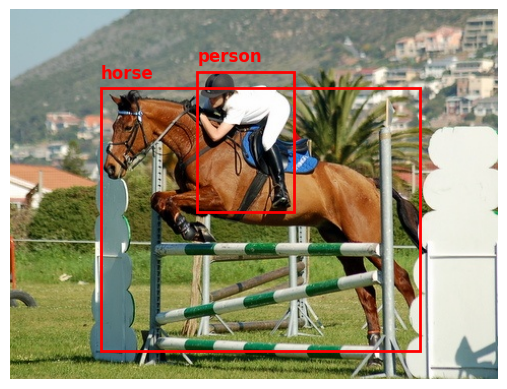

In [3]:
visualize_image(17)

In [25]:
# so now we have a dataset and we want to create a CNN to train on it and recognize objects in images

import torch
import torch.nn as nn
import torch.optim as optim

class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            # Block 1 (Filters: 16)
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, padding=1), # Added layer
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            # Block 2 (Filters: 32)
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1), # Added layer
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            # Block 3 (Filters: 64)
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), # Added layer
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Classifier
        # Input features: 64 (from last conv block)
        self.classifier = nn.Sequential(
            nn.Linear(64, 256),
            nn.LeakyReLU(0.1),
            # NOTE: We do not put Sigmoid here because we use BCEWithLogitsLoss
            # which includes sigmoid internally for numerical stability.
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

num_classes = len(train_data['categories'])
model = CNN(num_classes)
# Change: Use BCEWithLogitsLoss for multi-label classification (multi-object)
# This loss expects unnormalized LOGITS, not probabilities.
criterion = nn.BCEWithLogitsLoss()
# Slightly increase learning rate or keep standard, but add weight decay
optimizer = optim.Adam(model.parameters(), lr=0.0015, weight_decay=1e-5)

# now we need to train it on the dataset
# but first we need to create a DataLoader for the dataset
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class PascalVOCDataset(Dataset):
    def __init__(self, data, root, transform=None, num_classes=20):
        self.data = data
        self.root = root
        self.transform = transform
        self.num_classes = num_classes

    def __len__(self):
        return len(self.data['images'])

    def __getitem__(self, idx):
        image_info = self.data['images'][idx]
        fname = image_info['file_name']

        image_path = None
        for c in candidate_image_paths(fname):
            if os.path.exists(c):
                image_path = c
                break

        if image_path is None:
            raise FileNotFoundError(
                f"Image {fname} not found. Tried paths: {[str(p) for p in candidate_image_paths(fname)]}")

        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        # Change: The target becomes a presence vector (multi-hot encoding)
        label = torch.zeros(self.num_classes, dtype=torch.float32)
        annotations = [ann for ann in self.data['annotations'] if ann['image_id'] == image_info['id']]
        
        for ann in annotations:
            # Assuming category_id starts from 1
            cat_idx = ann['category_id'] - 1
            if 0 <= cat_idx < self.num_classes:
                label[cat_idx] = 1.0

        return image, label

from torchvision import transforms

# We add Data Augmentation to make the model more robust
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Standard ImageNet Normalization
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = PascalVOCDataset(train_data, dataset_root, transform=transform_train, num_classes=num_classes)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Prepare Validation DataLoader
# Load validation dataset here to use it during training
val_dataset = PascalVOCDataset(val_data, dataset_root, transform=transform_val, num_classes=num_classes)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [10]:
import torch
print("torch version:", torch.__version__)
print("torch.version.cuda:", torch.version.cuda)
print("cuda available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("device name:", torch.cuda.get_device_name(0))
    print("device count:", torch.cuda.device_count())

torch version: 2.6.0+cu124
torch.version.cuda: 12.4
cuda available: True
device name: NVIDIA GeForce RTX 3060 Laptop GPU
device count: 1


In [ ]:
# training loop
from tqdm.notebook import tqdm
import torch

def train_classification_model(model, train_loader, val_loader, criterion, optimizer, scheduler=None, num_epochs=15, device=None, save_name="model"):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    print(f"Training on device: {device}")
    if device.type == 'cuda':
        print(f"Using GPU: {torch.cuda.get_device_name(0)}")

    model.to(device)
    
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_accuracy': [],
        'val_precision': [], 
        'val_recall': [], 
        'val_f1': [] 
    }

    for epoch in range(num_epochs):
        # --- Training Phase ---
        model.train()
        running_loss = 0.0
        total_batches = len(train_loader)
        
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False)
        
        for batch_idx, (images, labels) in enumerate(progress_bar):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels) # BCEWithLogitsLoss
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            progress_bar.set_postfix({'loss': loss.item()})
        
        avg_train_loss = running_loss / total_batches
        history['train_loss'].append(avg_train_loss)
        
        # --- Validation Phase ---
        model.eval()
        val_running_loss = 0.0
        val_tp, val_tn, val_fp, val_fn = 0, 0, 0, 0
        total_val_batches = len(val_loader)
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                
                # Metric calculation
                probs = torch.sigmoid(outputs)
                predicted = (probs > 0.5).float()
                
                # Element-wise stats
                val_tp += (predicted * labels).sum().item()
                val_tn += ((1 - predicted) * (1 - labels)).sum().item()
                val_fp += (predicted * (1 - labels)).sum().item()
                val_fn += ((1 - predicted) * labels).sum().item()
                
        avg_val_loss = val_running_loss / total_val_batches
        history['val_loss'].append(avg_val_loss)
        
        # Calculate aggregate metrics
        epsilon = 1e-7
        accuracy = (val_tp + val_tn) / (val_tp + val_tn + val_fp + val_fn + epsilon)
        precision = val_tp / (val_tp + val_fp + epsilon)
        recall = val_tp / (val_tp + val_fn + epsilon)
        f1 = 2 * (precision * recall) / (precision + recall + epsilon)
        
        history['val_accuracy'].append(accuracy)
        history['val_precision'].append(precision)
        history['val_recall'].append(recall)
        history['val_f1'].append(f1)
        
        current_lr = optimizer.param_groups[0]['lr']
        if scheduler:
            scheduler.step()
            current_lr = scheduler.get_last_lr()[0]
        
        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {avg_train_loss:.4f} | "
              f"Val Loss: {avg_val_loss:.4f} | "
              f"Val Acc: {accuracy:.4f} | "
              f"Val F1: {f1:.4f} | "
              f"LR: {current_lr:.6f}")

    # save the trained model
    if save_name:
        torch.save(model.state_dict(), f"{save_name}.pth")
        torch.save(history, f"{save_name}_history.pth")
    
    return history

# Optional: Learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.8)

# Run training
num_epochs = 15
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
history = train_classification_model(model, dataloader, val_dataloader, criterion, optimizer, scheduler, num_epochs, device, save_name="cnn_pascalvoc")

Training on device: cuda
Using GPU: NVIDIA GeForce RTX 3060 Laptop GPU


Epoch 1/15 [Train]:   0%|          | 0/40 [00:00<?, ?it/s]

Training on device: cuda
Using GPU: NVIDIA GeForce RTX 3060 Laptop GPU


Epoch 1/15 [Train]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/15 | Train Loss: 0.2985 | Val Loss: 0.2465 | Val Acc: 0.9222 | Val F1: 0.0995 | LR: 0.001500


Epoch 2/15 [Train]:   0%|          | 0/40 [00:00<?, ?it/s]

Training on device: cuda
Using GPU: NVIDIA GeForce RTX 3060 Laptop GPU


Epoch 1/15 [Train]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/15 | Train Loss: 0.2985 | Val Loss: 0.2465 | Val Acc: 0.9222 | Val F1: 0.0995 | LR: 0.001500


Epoch 2/15 [Train]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 2/15 | Train Loss: 0.2394 | Val Loss: 0.2362 | Val Acc: 0.9221 | Val F1: 0.0560 | LR: 0.001500


Epoch 3/15 [Train]:   0%|          | 0/40 [00:00<?, ?it/s]

Training on device: cuda
Using GPU: NVIDIA GeForce RTX 3060 Laptop GPU


Epoch 1/15 [Train]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/15 | Train Loss: 0.2985 | Val Loss: 0.2465 | Val Acc: 0.9222 | Val F1: 0.0995 | LR: 0.001500


Epoch 2/15 [Train]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 2/15 | Train Loss: 0.2394 | Val Loss: 0.2362 | Val Acc: 0.9221 | Val F1: 0.0560 | LR: 0.001500


Epoch 3/15 [Train]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 3/15 | Train Loss: 0.2352 | Val Loss: 0.2289 | Val Acc: 0.9238 | Val F1: 0.1632 | LR: 0.001500


Epoch 4/15 [Train]:   0%|          | 0/40 [00:00<?, ?it/s]

Training on device: cuda
Using GPU: NVIDIA GeForce RTX 3060 Laptop GPU


Epoch 1/15 [Train]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/15 | Train Loss: 0.2985 | Val Loss: 0.2465 | Val Acc: 0.9222 | Val F1: 0.0995 | LR: 0.001500


Epoch 2/15 [Train]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 2/15 | Train Loss: 0.2394 | Val Loss: 0.2362 | Val Acc: 0.9221 | Val F1: 0.0560 | LR: 0.001500


Epoch 3/15 [Train]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 3/15 | Train Loss: 0.2352 | Val Loss: 0.2289 | Val Acc: 0.9238 | Val F1: 0.1632 | LR: 0.001500


Epoch 4/15 [Train]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 4/15 | Train Loss: 0.2303 | Val Loss: 0.2249 | Val Acc: 0.9237 | Val F1: 0.2293 | LR: 0.001500


Epoch 5/15 [Train]:   0%|          | 0/40 [00:00<?, ?it/s]

Training on device: cuda
Using GPU: NVIDIA GeForce RTX 3060 Laptop GPU


Epoch 1/15 [Train]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/15 | Train Loss: 0.2985 | Val Loss: 0.2465 | Val Acc: 0.9222 | Val F1: 0.0995 | LR: 0.001500


Epoch 2/15 [Train]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 2/15 | Train Loss: 0.2394 | Val Loss: 0.2362 | Val Acc: 0.9221 | Val F1: 0.0560 | LR: 0.001500


Epoch 3/15 [Train]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 3/15 | Train Loss: 0.2352 | Val Loss: 0.2289 | Val Acc: 0.9238 | Val F1: 0.1632 | LR: 0.001500


Epoch 4/15 [Train]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 4/15 | Train Loss: 0.2303 | Val Loss: 0.2249 | Val Acc: 0.9237 | Val F1: 0.2293 | LR: 0.001500


Epoch 5/15 [Train]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 5/15 | Train Loss: 0.2238 | Val Loss: 0.2411 | Val Acc: 0.9223 | Val F1: 0.2714 | LR: 0.001200


Epoch 6/15 [Train]:   0%|          | 0/40 [00:00<?, ?it/s]

Training on device: cuda
Using GPU: NVIDIA GeForce RTX 3060 Laptop GPU


Epoch 1/15 [Train]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/15 | Train Loss: 0.2985 | Val Loss: 0.2465 | Val Acc: 0.9222 | Val F1: 0.0995 | LR: 0.001500


Epoch 2/15 [Train]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 2/15 | Train Loss: 0.2394 | Val Loss: 0.2362 | Val Acc: 0.9221 | Val F1: 0.0560 | LR: 0.001500


Epoch 3/15 [Train]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 3/15 | Train Loss: 0.2352 | Val Loss: 0.2289 | Val Acc: 0.9238 | Val F1: 0.1632 | LR: 0.001500


Epoch 4/15 [Train]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 4/15 | Train Loss: 0.2303 | Val Loss: 0.2249 | Val Acc: 0.9237 | Val F1: 0.2293 | LR: 0.001500


Epoch 5/15 [Train]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 5/15 | Train Loss: 0.2238 | Val Loss: 0.2411 | Val Acc: 0.9223 | Val F1: 0.2714 | LR: 0.001200


Epoch 6/15 [Train]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 6/15 | Train Loss: 0.2234 | Val Loss: 0.2211 | Val Acc: 0.9234 | Val F1: 0.2587 | LR: 0.001200


Epoch 7/15 [Train]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 7/15 | Train Loss: 0.2202 | Val Loss: 0.2183 | Val Acc: 0.9235 | Val F1: 0.1371 | LR: 0.001200


Epoch 8/15 [Train]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 8/15 | Train Loss: 0.2177 | Val Loss: 0.2235 | Val Acc: 0.9224 | Val F1: 0.0289 | LR: 0.001200


Epoch 9/15 [Train]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 9/15 | Train Loss: 0.2160 | Val Loss: 0.2166 | Val Acc: 0.9246 | Val F1: 0.2219 | LR: 0.001200


Epoch 10/15 [Train]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 10/15 | Train Loss: 0.2176 | Val Loss: 0.2254 | Val Acc: 0.9228 | Val F1: 0.1982 | LR: 0.000960


Epoch 11/15 [Train]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 11/15 | Train Loss: 0.2141 | Val Loss: 0.2075 | Val Acc: 0.9253 | Val F1: 0.2368 | LR: 0.000960


Epoch 12/15 [Train]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 12/15 | Train Loss: 0.2088 | Val Loss: 0.2067 | Val Acc: 0.9247 | Val F1: 0.2265 | LR: 0.000960


Epoch 13/15 [Train]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 13/15 | Train Loss: 0.2073 | Val Loss: 0.2065 | Val Acc: 0.9247 | Val F1: 0.2154 | LR: 0.000960


Epoch 14/15 [Train]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 14/15 | Train Loss: 0.2045 | Val Loss: 0.2077 | Val Acc: 0.9249 | Val F1: 0.2637 | LR: 0.000960


Epoch 15/15 [Train]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 15/15 | Train Loss: 0.2037 | Val Loss: 0.2041 | Val Acc: 0.9255 | Val F1: 0.2620 | LR: 0.000768


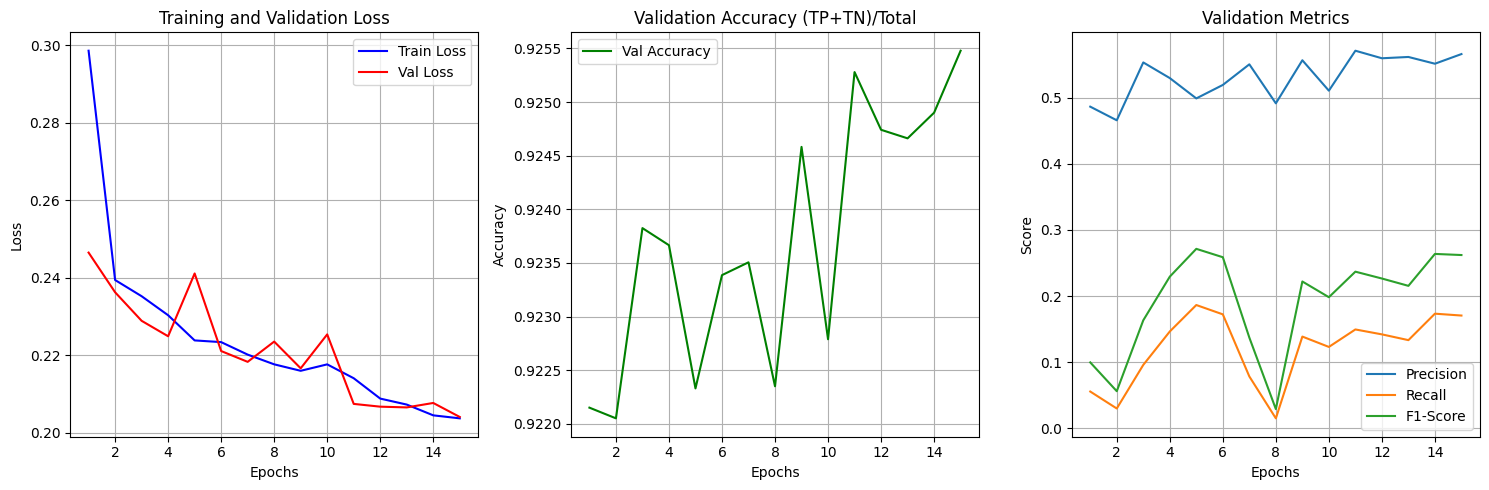

In [27]:
# Plotting Training History
import matplotlib.pyplot as plt

def plot_history(history):
    epochs = range(1, len(history['train_loss']) + 1)
    
    plt.figure(figsize=(15, 5))
    
    # Plot Losses
    plt.subplot(1, 3, 1)
    plt.plot(epochs, history['train_loss'], 'b-', label='Train Loss')
    plt.plot(epochs, history['val_loss'], 'r-', label='Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot Accuracy
    plt.subplot(1, 3, 2)
    plt.plot(epochs, history['val_accuracy'], 'g-', label='Val Accuracy')
    plt.title('Validation Accuracy (TP+TN)/Total')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    # Plot Precision/Recall/F1
    plt.subplot(1, 3, 3)
    plt.plot(epochs, history['val_precision'], label='Precision')
    plt.plot(epochs, history['val_recall'], label='Recall')
    plt.plot(epochs, history['val_f1'], label='F1-Score')
    plt.title('Validation Metrics')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

plot_history(history)

In [ ]:
# Evaluation on TEST SET with mAP (Mean Average Precision)
from torch.utils.data import DataLoader
import numpy as np

# Funzione per calcolare AP stile VOC2007 (11-point interpolation)
def calculate_voc_ap(recall, precision):
    ap = 0.0
    for t in np.arange(0.0, 1.1, 0.1):
        if np.sum(recall >= t) == 0:
            p = 0
        else:
            p = np.max(precision[recall >= t])
        ap += p / 11.0
    return ap

def evaluate_classification_mAP(model, data_loader, num_classes, categories=None, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    print(f"Starting evaluation on TEST SET (mAP Calculation)...")
    model.to(device)
    model.eval()

    # 2. Inference Loop
    all_targets = []
    all_probs = []

    with torch.no_grad():
        for images, labels in tqdm(data_loader, desc="Test Inference"):
            images = images.to(device)
            outputs = model(images)
            probs = torch.sigmoid(outputs)
            
            all_probs.append(probs.cpu().numpy())
            all_targets.append(labels.cpu().numpy())

    # Concatenate all batches
    y_true = np.concatenate(all_targets, axis=0) # [N, num_classes]
    y_prob = np.concatenate(all_probs, axis=0)   # [N, num_classes]

    # 3. Calcolo mAP per Classe
    print(f"\n{'ID':<4} {'Class Name':<15} {'AP (VOC07)':<12} {'Support (GT Pos)'}")
    print("-" * 60)

    idx_to_name = {}
    if categories is not None:
        try:
            # Assuming categories list of dicts with 'id' and 'name'
            # Assuming category IDs are 1-based and map to 0-based index i -> i+1
            idx_to_name = {cat['id']-1: cat['name'] for cat in categories}
        except:
            pass
    
    if not idx_to_name:
        idx_to_name = {i: f"Class {i+1}" for i in range(num_classes)}

    ap_list = []

    for i in range(num_classes):
        # Dati per la classe i
        scores = y_prob[:, i]
        targets = y_true[:, i]
        
        # Numero totale di positivi
        npos = np.sum(targets)
        if npos == 0:
            ap = 0.0
        else:
            # Ordina per score decrescente
            sorted_indices = np.argsort(-scores)
            sorted_targets = targets[sorted_indices]
            
            # Calcola TP e FP cumulativi
            tp = sorted_targets
            fp = 1 - sorted_targets
            
            tp_cum = np.cumsum(tp)
            fp_cum = np.cumsum(fp)
            
            # Precision e Recall
            recall = tp_cum / npos
            precision = tp_cum / (tp_cum + fp_cum + 1e-8)
            
            # Calcola AP
            ap = calculate_voc_ap(recall, precision)

        ap_list.append(ap)
        
        name = idx_to_name.get(i, f"Class {i+1}")
        print(f"{i+1:<4} {name:<15} {ap:.4f}         {int(npos)}")

    print("-" * 60)
    mAP = np.mean(ap_list)
    print(f"Mean Average Precision (mAP): {mAP:.4f}")
    return mAP

# 1. Setup Test Dataset & Loader
test_dataset = PascalVOCDataset(eval_data, dataset_root, transform=transform_val, num_classes=num_classes)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Run evaluation for Custom CNN
evaluate_classification_mAP(model, test_dataloader, num_classes, train_data['categories'])

Starting evaluation on TEST SET (mAP Calculation)...


Test Inference:   0%|          | 0/78 [00:00<?, ?it/s]


ID   Class Name      AP (VOC07)   Support (GT Pos)
------------------------------------------------------------
1    aeroplane       0.4741         205
2    bicycle         0.1403         250
3    bird            0.2373         289
4    boat            0.3403         176
5    bottle          0.1312         240
6    bus             0.1933         183
7    car             0.4145         775
8    cat             0.3075         332
9    chair           0.4032         545
10   cow             0.1862         127
11   diningtable     0.3236         247
12   dog             0.2617         433
13   horse           0.1977         279
14   motorbike       0.2105         233
15   person          0.6282         2097
16   pottedplant     0.1953         254
17   sheep           0.1542         98
18   sofa            0.3057         355
19   train           0.2609         259
20   tvmonitor       0.2380         255
------------------------------------------------------------
mAP (Mean Average Precisio

# Intermediate Step: Object Classification with Pre-trained ResNet50

In this section, we use a pre-trained ResNet50 model (the backbone of Faster R-CNN) and fine-tune it for the classification task. This serves as a "fair" comparison between the custom CNN and the object detection model, using valid metrics.

In [ ]:
from torchvision.models import resnet50, ResNet50_Weights
import torch.nn as nn
import torch.optim as optim
import torch

# Intermediate Step: Setup ResNet50 for Classification
# Load pre-trained ResNet50
print("Loading ResNet50...")
weights = ResNet50_Weights.DEFAULT
resnet_model = resnet50(weights=weights)

# Freeze backbone parameters to ensure fair comparison with detection model (which usually freezes backbone)
for param in resnet_model.parameters():
    param.requires_grad = False
    
# Replace the FC layer
num_ftrs = resnet_model.fc.in_features
# We replace the final layer, so these new parameters will be trainable
resnet_model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, num_classes) 
)

# Move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet_model.to(device)

# Optimizer - only for trainable parameters
# Using Adam as a "middle ground" optimizer (used in Custom CNN)
optimizer_resnet = optim.Adam(resnet_model.parameters(), lr=0.001)

criterion = nn.BCEWithLogitsLoss()

print("ResNet50 model initialized for classification (Backbone Frozen, Head Trainable).")

In [ ]:
# Train ResNet50
print("Training ResNet50 for Classification...")
history_resnet = train_classification_model(
    resnet_model, 
    dataloader, 
    val_dataloader, 
    criterion, 
    optimizer_resnet, 
    num_epochs=15, 
    device=device,
    save_name="resnet50_pascalvoc"
)

In [ ]:
# Plot ResNet50 History
plot_history(history_resnet)

In [ ]:
# Evaluate ResNet50 Classification
print("Evaluating ResNet50 Classification...")
evaluate_classification_mAP(resnet_model, test_dataloader, num_classes, train_data['categories'])

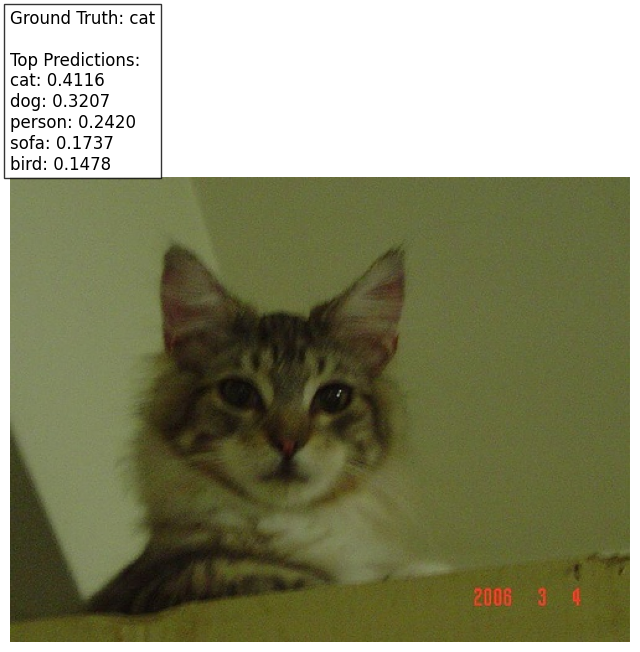

In [39]:
# Visualize an image from the validation dataset with model predictions

# Ensure val_data is available (in case previous cells were skipped)
if 'val_data' not in locals() and 'val_data' not in globals():
    with open(val_json, 'r') as f:
        val_data = json.load(f)

def visualize_image_with_predictions(image_id):
    image_info = next(img for img in val_data['images'] if img['id'] == image_id)
    fname = image_info['file_name']

    image_path = None
    for c in candidate_image_paths(fname):
        if os.path.exists(c):
            image_path = c
            break

    if image_path is None:
        raise FileNotFoundError(
            f"Image {fname} not found. Tried paths: {[str(p) for p in candidate_image_paths(fname)]}")

    image = plt.imread(image_path)
    # Preprocess image using transform_val instead of undefined transform
    input_tensor = transform_val(Image.open(image_path).convert('RGB')).unsqueeze(0)

    # Move to same device as model
    input_tensor = input_tensor.to(device)
    model.to(device)
    model.eval()

    with torch.no_grad():
        outputs = model(input_tensor)
        probs = torch.sigmoid(outputs)[0] # Get probabilities for first image in batch

    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.imshow(image)
    ax.axis('off')

    # Get Ground Truth
    annotations = [ann for ann in val_data['annotations'] if ann['image_id'] == image_id]
    gt_category_ids = {ann['category_id'] for ann in annotations}
    gt_names = []
    for cat_id in gt_category_ids:
         cat_info = next((cat for cat in val_data['categories'] if cat['id'] == cat_id), None)
         if cat_info:
             gt_names.append(cat_info['name'])
    
    # Get Top Predictions
    predictions = []
    for i in range(num_classes):
        # Infer category ID. Assuming 1-based index corresponding to i+1
        score = probs[i].item()
        cat_id = i + 1 
        cat_info = next((cat for cat in val_data['categories'] if cat['id'] == cat_id), None)
        name = cat_info['name'] if cat_info else f"Unknown-{cat_id}"
        predictions.append((name, score))
    
    # Sort by score desc
    predictions.sort(key=lambda x: x[1], reverse=True)
    
    # Display text
    title_text = f"Ground Truth: {', '.join(gt_names)}\n\nTop Predictions:"
    for name, score in predictions[:5]:
        title_text += f"\n{name}: {score:.4f}"
        
    plt.title(title_text, loc='left', fontsize=12, bbox=dict(facecolor='white', alpha=0.8))
    plt.show()

# Pick a random image if no ID is specified
import random
random_image_id = random.choice(val_data['images'])['id']
visualize_image_with_predictions(random_image_id)

In [44]:
# Dataset per Object Detection (torchvision detection API)
import torch
from torch.utils.data import Dataset
from PIL import Image
import os

class PascalVOCDatasetDet(Dataset):
    """Restituisce (image, target) per ogni immagine.
    target: dict con chiavi 'boxes' [N,4] (xyxy), 'labels' [N], 'image_id', 'area', 'iscrowd'.
    """
    def __init__(self, data, root, transforms=None):
        self.data = data
        self.root = root
        self.transforms = transforms
        self.images = self.data['images']
        # Precalcola annotazioni per immagine
        self.by_image = {}
        for ann in self.data['annotations']:
            self.by_image.setdefault(ann['image_id'], []).append(ann)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        info = self.images[idx]
        img_id = info['id']
        fname = info['file_name']
        image_path = None
        for c in candidate_image_paths(fname):
            if os.path.exists(c):
                image_path = c
                break

        if image_path is None:
            raise FileNotFoundError(
                f"Image {fname} not found. Tried paths: {[str(p) for p in candidate_image_paths(fname)]}")

        img = Image.open(image_path).convert("RGB")
        width, height = img.size

        anns = self.by_image.get(img_id, [])
        boxes = []
        labels = []
        areas = []
        for a in anns:
            x, y, w, h = a['bbox']  # COCO-style [x, y, w, h]
            x1, y1, x2, y2 = x, y, x + w, y + h  # convert to xyxy
            # clamp nei bounds dell'immagine
            x1 = max(0, min(x1, width - 1))
            y1 = max(0, min(y1, height - 1))
            x2 = max(0, min(x2, width))
            y2 = max(0, min(y2, height))
            if x2 > x1 and y2 > y1:
                boxes.append([x1, y1, x2, y2])
                labels.append(a['category_id'])  # 1..num_classes (0 = sfondo)
                areas.append((x2 - x1) * (y2 - y1))

        import torchvision.transforms as T
        if self.transforms is not None:
            img = self.transforms(img)
        else:
            img = T.ToTensor()(img)  # niente resize per non rompere i box

        target = {
            'boxes': torch.as_tensor(boxes, dtype=torch.float32),
            'labels': torch.as_tensor(labels, dtype=torch.int64),
            'image_id': torch.tensor([img_id]),
            'area': torch.as_tensor(areas, dtype=torch.float32),
            'iscrowd': torch.zeros((len(labels),), dtype=torch.int64)
        }
        return img, target


def det_collate_fn(batch):
    # batch: list of (image, target)
    return tuple(zip(*batch))

In [45]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

num_classes = 20 + 1  # 20 classi + background
weights = FasterRCNN_ResNet50_FPN_Weights.COCO_V1
model_det = fasterrcnn_resnet50_fpn(weights=weights)  # backbone+RPN+ROI heads preaddestrati

# Sostituisci la testa di classificazione/regressione box per le tue classi
in_features = model_det.roi_heads.box_predictor.cls_score.in_features
model_det.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model_det.train()  # poi avvii il training sul tuo DataLoader detection

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [46]:
# Dataset, DataLoader e optimizer per Object Detection (congelando backbone+RPN)
import torch
from torch.utils.data import DataLoader

# Dataset/train loader (VOC detection)
train_det_dataset = PascalVOCDatasetDet(train_data, dataset_root, transforms=None)
train_det_loader = DataLoader(
    train_det_dataset,
    batch_size=4,           # batch piccolo per RAM/CPU
    shuffle=True,
    num_workers=0,          # su Windows spesso 0 è più stabile
    collate_fn=det_collate_fn
)

# Device handling
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model_det.to(device)

# Congela backbone e RPN (i pesi COCO restano fissi)
for p in model_det.backbone.parameters():
    p.requires_grad = False
for p in model_det.rpn.parameters():
    p.requires_grad = False

# Parametri allenabili: solo ROI heads box_head + box_predictor
trainable_params = []
for p in model_det.roi_heads.box_head.parameters():
    p.requires_grad = True
    trainable_params.append(p)
for p in model_det.roi_heads.box_predictor.parameters():
    p.requires_grad = True
    trainable_params.append(p)

# Optimizer solo per i parametri trainabili
optimizer_det = torch.optim.SGD(trainable_params, lr=0.01, momentum=0.9, weight_decay=0.0005)

In [47]:
# Training/Caricamento per Object Detection (Faster R-CNN) con backbone+RPN congelati
from tqdm.notebook import tqdm
import torch, os

model_det_path = "fasterrcnn_voc.pth"

if os.path.exists(model_det_path):
    # Carica e usa direttamente senza retraining
    state = torch.load(model_det_path, map_location=device)
    model_det.load_state_dict(state)
    model_det.eval()
    print(f"Modello detection caricato da: {model_det_path}. Training saltato.")
else:
    print("Nessun modello detection salvato trovato. Avvio training e salvataggio...")
    num_epochs_det = 1
    for epoch in range(num_epochs_det):
        model_det.train()
        running = 0.0
        for images, targets in tqdm(train_det_loader, desc=f"Det Epoch {epoch+1}/{num_epochs_det}"):
            # sposta batch su device
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model_det(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            optimizer_det.zero_grad()
            losses.backward()
            optimizer_det.step()

            running += losses.item()
        print(f"[DET] Epoch {epoch+1}/{num_epochs_det} - Loss: {running/max(1, len(train_det_loader)):.4f}")

    # Salvataggio modello detection
    torch.save(model_det.state_dict(), model_det_path)
    print("Modello detection salvato:", model_det_path)
    model_det.eval()

Modello detection caricato da: fasterrcnn_voc.pth. Training saltato.


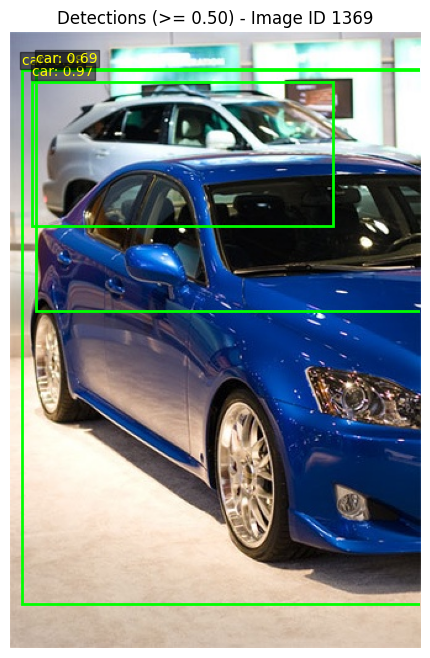

In [48]:
# [FONDO] Visualizzazione detection (ridefinita qui per rimanere in fondo)
import os, random
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.transforms as T
from PIL import Image

# mappa id->name per labels (1..num_classes) da VOC
id_to_name = {cat['id']: cat['name'] for cat in train_data['categories']}

def visualize_detections(image_id=None, ds=None, score_thresh=0.5, max_dets=50):
    if ds is None:
        raise ValueError("please specify dataset as 'ds' parameter")

    imgs = ds['images']

    if image_id is None:
        image_id = random.choice(imgs)['id']

    info = next(img for img in imgs if img['id'] == image_id)
    fname = info['file_name']

    image_path = None
    for c in candidate_image_paths(fname):
        if os.path.exists(c):
            image_path = c
            break

    if image_path is None:
        raise FileNotFoundError(
            f"Image {fname} not found. Tried paths: {[str(p) for p in candidate_image_paths(fname)]}")

    # carica immagine (no resize per detection)
    pil_img = Image.open(image_path).convert('RGB')
    img_tensor = T.ToTensor()(pil_img)

    model_det.eval()
    with torch.no_grad():
        outputs = model_det([img_tensor.to(device)])[0]

    boxes = outputs.get('boxes', torch.empty((0, 4)))
    labels = outputs.get('labels', torch.empty((0,), dtype=torch.long))
    scores = outputs.get('scores', torch.empty((0,)))

    # filtra per soglia
    keep = (scores >= score_thresh).nonzero(as_tuple=False).squeeze(1)
    boxes = boxes[keep][:max_dets].cpu()
    labels = labels[keep][:max_dets].cpu()
    scores = scores[keep][:max_dets].cpu()

    # plot
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    ax.imshow(pil_img)
    for b, lab, sc in zip(boxes, labels, scores):
        x1, y1, x2, y2 = b.tolist()
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='lime', facecolor='none')
        ax.add_patch(rect)
        name = id_to_name.get(int(lab), str(int(lab)))
        ax.text(x1, max(0, y1 - 5), f"{name}: {float(sc):.2f}", color='yellow', fontsize=10, bbox=dict(facecolor='black', alpha=0.5, pad=1))
    ax.set_title(f"Detections (>= {score_thresh:.2f}) - Image ID {image_id}")
    ax.axis('off')
    plt.show()

# Esempio d'uso:
visualize_detections(ds=eval_data, score_thresh=0.5)

In [49]:
# [FONDO] Valutazione Detection su Test Set
# Calcolo metriche mAP
import torch
import numpy as np
from tqdm.notebook import tqdm
from torchvision.ops import box_iou
from torch.utils.data import DataLoader

# 1. SETUP DATASET & DATALOADER
# Batch size > 1 per essere più efficienti con la GPU
eval_det_dataset = PascalVOCDatasetDet(eval_data, dataset_root, transforms=None)
eval_det_loader = DataLoader(
    eval_det_dataset,
    batch_size=8, 
    shuffle=False, 
    num_workers=0,
    collate_fn=det_collate_fn
)

# Funzione standard per AP (Interpolazione 11 punti)
def calculate_voc_ap(recall, precision):
    ap = 0.0
    for t in np.arange(0.0, 1.1, 0.1):
        if np.sum(recall >= t) == 0:
            p = 0
        else:
            p = np.max(precision[recall >= t])
        ap += p / 11.0
    return ap

# 2. INFERENZA E RACCOLTA DATI
print("Avvio valutazione su Test Set...")
model_det.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_det.to(device)

# Strutture per raccogliere i dati
# ground_truths[global_img_id] = { 'boxes': tensor, 'labels': tensor }
ground_truths = {}
# detections[class_id] = [ (score, global_img_id, box_tensor), ... ]
detections = {i: [] for i in range(1, 21)} # Classi 1-20

with torch.no_grad():
    for i, batch in enumerate(tqdm(eval_det_loader, desc="Inference")):
        images, targets = batch
        images = [img.to(device) for img in images]
        
        # Passaggio al modello
        outputs = model_det(images)
        
        # Salviamo sia GT che Predizioni
        for j, output in enumerate(outputs):
            global_img_id = i * eval_det_loader.batch_size + j
            
            # --- Ground Truth ---
            # Spostiamo su CPU per non intasare la GPU
            tgt_boxes = targets[j]['boxes'].cpu()
            tgt_labels = targets[j]['labels'].cpu()
            ground_truths[global_img_id] = {'boxes': tgt_boxes, 'labels': tgt_labels}
            
            # --- Predizioni ---
            pred_boxes = output['boxes'].cpu()
            pred_scores = output['scores'].cpu()
            pred_labels = output['labels'].cpu()
            
            for k in range(len(pred_scores)):
                cls_id = int(pred_labels[k])
                score = float(pred_scores[k])
                box = pred_boxes[k]
                
                # Ignoriamo label fuori dal range VOC (es. background 0) se ce ne fossero
                if cls_id in detections:
                    detections[cls_id].append((score, global_img_id, box))

# 3. CALCOLO mAP PER CLASSE
print("\nRisultati Evaluation:")
print(f"{'ID':<4} {'Class Name':<15} {'AP (VOC07)':<12} {'Support (GT Pos)'}")
print("-" * 65)

ap_list = []
iou_threshold = 0.5
name_by_id = {cat['id']: cat['name'] for cat in train_data['categories']}
sorted_ids = sorted([i for i in range(1, 21) if i in name_by_id])

for cls_id in sorted_ids:
    # 3.1 Recupera predizioni e GT per questa classe
    dets = detections[cls_id]
    
    # Prepara GT specifici per questa classe
    # Map: img_id -> {'boxes': boxes_di_questa_classe, 'detected': array_bool}
    class_gt = {}
    npos = 0 # Numero totale di oggetti veri per questa classe
    for img_id, gt in ground_truths.items():
        mask = (gt['labels'] == cls_id)
        boxes = gt['boxes'][mask]
        num_obj = boxes.shape[0]
        if num_obj > 0:
            npos += num_obj
            class_gt[img_id] = {'boxes': boxes, 'detected': np.zeros(num_obj, dtype=bool)}
            
    # Se non ci sono oggetti veri, AP = 0
    if npos == 0:
        ap = 0.0
    else:
        # 3.2 Ordina predizioni per confidenza (decrescente)
        dets.sort(key=lambda x: x[0], reverse=True)
        
        tp = np.zeros(len(dets))
        fp = np.zeros(len(dets))
        
        # 3.3 Confronta ogni predizione con i GT
        for d_idx, (score, img_id, pred_box) in enumerate(dets):
            # Se in questa immagine non c'erano oggetti di questa classe, è FP
            if img_id not in class_gt:
                fp[d_idx] = 1
                continue
            
            gt_data = class_gt[img_id]
            gt_boxes = gt_data['boxes']
            
            # Calcola IOU con tutti i box veri
            iou_matrix = box_iou(pred_box.unsqueeze(0), gt_boxes) # [1, N_gt]
            max_iou, max_idx = torch.max(iou_matrix, dim=1)
            max_iou = max_iou.item()
            max_idx = max_idx.item()
            
            if max_iou >= iou_threshold:
                if not gt_data['detected'][max_idx]:
                    tp[d_idx] = 1
                    gt_data['detected'][max_idx] = True # Segna come trovato
                else:
                    fp[d_idx] = 1 # Già trovato (duplicato)
            else:
                fp[d_idx] = 1 # IOU troppo basso
        
        # 3.4 Curve Precision-Recall
        tp_cum = np.cumsum(tp)
        fp_cum = np.cumsum(fp)
        recall = tp_cum / npos
        precision = tp_cum / np.maximum(tp_cum + fp_cum, 1e-8)
        
        ap = calculate_voc_ap(recall, precision)

    ap_list.append(ap)
    name = name_by_id.get(cls_id, f"Class {cls_id}")
    print(f"{cls_id:<4} {name:<15} {ap:.4f}         {int(npos)}")

print("-" * 65)
mAP = np.mean(ap_list) if ap_list else 0.0
print(f"Mean Average Precision (mAP): {mAP:.4f}")

Loading Ground Truth...
Running Inference...


  0%|          | 0/619 [00:00<?, ?it/s]

Calculating AP per class...

Faster R-CNN Detection mAP@0.5: 0.7353
ID   Class Name      AP (VOC07)   Support (GT Boxes)
-----------------------------------------------------------------
1    aeroplane       0.8105         311
2    bicycle         0.7910         389
3    bird            0.6994         576
4    boat            0.6090         393
5    bottle          0.6701         657
6    bus             0.8033         254
7    car             0.8509         1541
8    cat             0.8152         370
9    chair           0.5835         1374
10   cow             0.8101         329
11   diningtable     0.5723         299
12   dog             0.6774         530
13   horse           0.8112         395
14   motorbike       0.8189         369
15   person          0.8495         5227
16   pottedplant     0.5392         592
17   sheep           0.7690         311
18   sofa            0.6606         396
19   train           0.7831         302
20   tvmonitor       0.7823         361
----------